Files already downloaded and verified


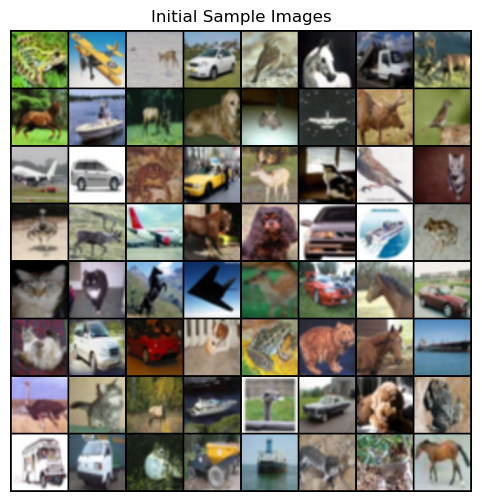

In [1]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import os

# Parameters
MODEL_PARAMS = {
    'epochs': 50,
    'batch_size': 128,
    'learning_rate': 0.0002, # Adam learning rate from DCGAN paper
    'beta1': 0.5, # Adam beta1 parameter from DCGAN paper
    'beta2': 0.999,
    'noise_dim': 100,
    'image_size': 64,
    'channels': 3,
    'gen_features': 64,
    'disc_features': 64,
}

# Setup directories
RESULTS_PATH = "DCGAN_results"
os.makedirs(os.path.join(RESULTS_PATH, "GeneratedImages"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_PATH, "RealImages"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_PATH, "Metrics"), exist_ok=True)

# Device configuration
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing
transform_pipeline = transforms.Compose([
    transforms.Resize(MODEL_PARAMS['image_size']),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
cifar_data = datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform_pipeline)
cifar_loader = DataLoader(cifar_data, 
                         batch_size=MODEL_PARAMS['batch_size'], 
                         shuffle=True, 
                         num_workers=2, 
                         pin_memory=True)

# Display initial samples
initial_samples = next(iter(cifar_loader))
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.title("Initial Sample Images")
plt.imshow(np.transpose(utils.make_grid(initial_samples[0][:64], padding=2, normalize=True), (1, 2, 0)))
plt.show()

In [2]:
# Cell 2: Generator and Discriminator Models
class Generator(nn.Module):
   def __init__(self, nz=100, ngf=64, nc=3):
       super(Generator, self).__init__()
        # Uses strided transposed convolutions instead of pooling
        # BatchNorm in all layers except output
        # ReLU activations
        # No fully connected layers
       self.main = nn.Sequential(
           nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
           nn.BatchNorm2d(ngf * 8, momentum=0.9),
           nn.ReLU(True),
           
           nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
           nn.BatchNorm2d(ngf * 4, momentum=0.9),
           nn.ReLU(True),
           
           nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
           nn.BatchNorm2d(ngf * 2, momentum=0.9),
           nn.ReLU(True),
           
           nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
           nn.BatchNorm2d(ngf, momentum=0.9),
           nn.ReLU(True),
           
           nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
           nn.Tanh()
       )

   def forward(self, x):
       return self.main(x)

class Discriminator(nn.Module):
   def __init__(self, nc=3, ndf=64):
       super(Discriminator, self).__init__()
        # Uses strided convolutions instead of pooling
        # BatchNorm in all layers except input and output
        # LeakyReLU activations
       self.main = nn.Sequential(
           nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
           nn.LeakyReLU(0.2, inplace=True),
           
           nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
           nn.BatchNorm2d(ndf * 2, momentum=0.9),
           nn.LeakyReLU(0.2, inplace=True),
           
           nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
           nn.BatchNorm2d(ndf * 4, momentum=0.9),
           nn.LeakyReLU(0.2, inplace=True),
           
           nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
           nn.BatchNorm2d(ndf * 8, momentum=0.9),
           nn.LeakyReLU(0.2, inplace=True),
           
           nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
           nn.Sigmoid()
       )

   def forward(self, x):
       return self.main(x)

def weight_init(m):
   if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
       nn.init.normal_(m.weight.data, 0.0, 0.02)

In [3]:
# Cell 3: Inception Model for Metrics
class QualityMetrics(nn.Module):
   def __init__(self):
       super(QualityMetrics, self).__init__()
       inception = models.inception_v3(pretrained=True)
       self.block1 = nn.Sequential(
           inception.Conv2d_1a_3x3, inception.Conv2d_2a_3x3,
           inception.Conv2d_2b_3x3,
           nn.MaxPool2d(kernel_size=3, stride=2)
       )
       self.block2 = nn.Sequential(
           inception.Conv2d_3b_1x1, inception.Conv2d_4a_3x3,
           nn.MaxPool2d(kernel_size=3, stride=2)
       )
       self.block3 = nn.Sequential(
           inception.Mixed_5b, inception.Mixed_5c,
           inception.Mixed_5d, inception.Mixed_6a,
           inception.Mixed_6b, inception.Mixed_6c,
           inception.Mixed_6d, inception.Mixed_6e
       )
       self.block4 = nn.Sequential(
           inception.Mixed_7a, inception.Mixed_7b,
           inception.Mixed_7c,
           nn.AdaptiveAvgPool2d(output_size=(1, 1))
       )
       
   def forward(self, x):
       x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
       x = 2 * x - 1
       x = self.block1(x)
       x = self.block2(x)
       x = self.block3(x)
       x = self.block4(x)
       return x.view(x.size(0), -1)

metrics_model = QualityMetrics().to(device)
metrics_model.eval()

def get_feature_stats(images, model):
   with torch.no_grad():
       pred = model(images)
       mu = pred.mean(dim=0).cpu().numpy()
       sigma = np.cov(pred.cpu().numpy(), rowvar=False)
   return mu, sigma

def calculate_statistical_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
   mu1, mu2 = np.atleast_1d(mu1), np.atleast_1d(mu2)
   sigma1, sigma2 = np.atleast_2d(sigma1), np.atleast_2d(sigma2)

   diff = mu1 - mu2
   covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
   
   if not np.isfinite(covmean).all():
       offset = np.eye(sigma1.shape[0]) * eps
       covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

   if np.iscomplexobj(covmean):
       covmean = covmean.real

   tr_covmean = np.trace(covmean)
   return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

def compute_quality_score(real_imgs, fake_imgs, model):
   mu1, sigma1 = get_feature_stats(real_imgs, model)
   mu2, sigma2 = get_feature_stats(fake_imgs, model)
   return calculate_statistical_distance(mu1, sigma1, mu2, sigma2)

/home/pchouda/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pchouda/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Cell 4: Image Saving and Plot Functions
def save_images(epoch, real_imgs, fake_imgs):
   # Save images without displaying
   utils.save_image(
       real_imgs, 
       os.path.join(RESULTS_PATH, f'RealImages/real_epoch_{epoch}.png'),
       normalize=True
   )
   utils.save_image(
       fake_imgs,
       os.path.join(RESULTS_PATH, f'GeneratedImages/generated_epoch_{epoch}.png'),
       normalize=True
   )

def plot_training_curves(gen_losses, disc_losses, quality_scores, accuracies):
   plt.figure(figsize=(15, 5))
   
   plt.subplot(1, 3, 1)
   plt.plot(gen_losses, label='Generator')
   plt.plot(disc_losses, label='Discriminator')
   plt.xlabel('Epoch')
   plt.ylabel('Loss')
   plt.legend()
   plt.title('Network Losses')

   plt.subplot(1, 3, 2)
   plt.plot(quality_scores)
   plt.xlabel('Epoch')
   plt.ylabel('FID Score')
   plt.title('Quality Metrics')

   plt.subplot(1, 3, 3)
   plt.plot(accuracies)
   plt.xlabel('Epoch')
   plt.ylabel('Accuracy (%)')
   plt.title('Discriminator Performance')
   
   plt.tight_layout()
   plt.savefig(os.path.join(RESULTS_PATH, 'Metrics/training_curves.png'))
   plt.show()

In [5]:
# Cell 5: Training Function
def train_networks(gen_model, disc_model, dataloader, num_epochs=MODEL_PARAMS['epochs']):
   gen_losses = []
   disc_losses = []
   quality_metrics = []
   disc_accuracies = []
   training_log = open(os.path.join(RESULTS_PATH, "Metrics/training_log.txt"), "w")
   
   criterion = nn.BCELoss()
   latent_vector = torch.randn(64, MODEL_PARAMS['noise_dim'], 1, 1, device=device)
   
   g_optimizer = optim.Adam(gen_model.parameters(), 
                           lr=MODEL_PARAMS['learning_rate'], 
                           betas=(MODEL_PARAMS['beta1'], MODEL_PARAMS['beta2']))
   d_optimizer = optim.Adam(disc_model.parameters(), 
                           lr=MODEL_PARAMS['learning_rate'], 
                           betas=(MODEL_PARAMS['beta1'], MODEL_PARAMS['beta2']))
   
   print("Beginning Training Process...")
   
   for epoch in range(num_epochs):
       epoch_d_loss = 0
       epoch_g_loss = 0
       correct_predictions = 0
       total_samples = 0
       
       for batch_idx, (real_images, _) in enumerate(dataloader):
           batch_size = real_images.size(0)
           real_images = real_images.to(device)
           
           # Train Discriminator
           d_optimizer.zero_grad()
           label_real = torch.ones(batch_size, 1, 1, 1).to(device)
           label_fake = torch.zeros(batch_size, 1, 1, 1).to(device)
           
           output_real = disc_model(real_images)
           d_loss_real = criterion(output_real, label_real)
           
           pred_real = (output_real > 0.5).float()
           correct_predictions += (pred_real == label_real).sum().item()
           
           noise = torch.randn(batch_size, MODEL_PARAMS['noise_dim'], 1, 1, device=device)
           fake_images = gen_model(noise)
           output_fake = disc_model(fake_images.detach())
           d_loss_fake = criterion(output_fake, label_fake)
           
           pred_fake = (output_fake > 0.5).float()
           correct_predictions += (pred_fake == label_fake).sum().item()
           
           total_samples += 2 * batch_size
           
           d_loss = d_loss_real + d_loss_fake
           d_loss.backward()
           d_optimizer.step()
           
           # Train Generator
           g_optimizer.zero_grad()
           output_fake = disc_model(fake_images)
           g_loss = criterion(output_fake, label_real)
           g_loss.backward()
           g_optimizer.step()
           
           epoch_d_loss += d_loss.item()
           epoch_g_loss += g_loss.item()
           
           if batch_idx % 100 == 0:
               current_accuracy = (correct_predictions / total_samples) * 100
               print(f'Epoch [{epoch}/{num_epochs}] Batch [{batch_idx}/{len(dataloader)}] '
                     f'Discriminator_Loss: {d_loss.item():.4f} Generator_Loss: {g_loss.item():.4f} '
                     f'Accuracy: {current_accuracy:.2f}%')
       
       # Calculate epoch metrics
       epoch_accuracy = (correct_predictions / total_samples) * 100
       avg_d_loss = epoch_d_loss / len(dataloader)
       avg_g_loss = epoch_g_loss / len(dataloader)
       
       with torch.no_grad():
           gen_images = gen_model(latent_vector)
           quality_score = compute_quality_score(real_images[:64], gen_images, metrics_model)
           save_images(epoch, real_images[:64], gen_images)
       
       log_entry = f"Epoch {epoch}: Discriminator_Loss={avg_d_loss:.4f}, Generator_Loss={avg_g_loss:.4f}, "
       log_entry += f"Accuracy={epoch_accuracy:.2f}%, Quality={quality_score:.4f}\n"
       training_log.write(log_entry)
       print(log_entry)
       
       gen_losses.append(avg_g_loss)
       disc_losses.append(avg_d_loss)
       disc_accuracies.append(epoch_accuracy)
       quality_metrics.append(quality_score)
   
   training_log.close()
   return gen_losses, disc_losses, quality_metrics, disc_accuracies

Training on cuda
Beginning Training Process...
Epoch [0/50] Batch [0/391] Discriminator_Loss: 1.3793 Generator_Loss: 0.7197 Accuracy: 64.45%
Epoch [0/50] Batch [100/391] Discriminator_Loss: 0.0294 Generator_Loss: 4.3075 Accuracy: 97.90%
Epoch [0/50] Batch [200/391] Discriminator_Loss: 0.0955 Generator_Loss: 3.7705 Accuracy: 96.27%
Epoch [0/50] Batch [300/391] Discriminator_Loss: 0.0916 Generator_Loss: 4.2089 Accuracy: 96.56%
Epoch 0: Discriminator_Loss=0.2986, Generator_Loss=3.7726, Accuracy=96.49%, Quality=472.2073

Epoch [1/50] Batch [0/391] Discriminator_Loss: 0.2237 Generator_Loss: 4.0138 Accuracy: 99.61%
Epoch [1/50] Batch [100/391] Discriminator_Loss: 0.4740 Generator_Loss: 2.7382 Accuracy: 89.63%
Epoch [1/50] Batch [200/391] Discriminator_Loss: 0.3646 Generator_Loss: 2.7477 Accuracy: 87.48%
Epoch [1/50] Batch [300/391] Discriminator_Loss: 0.9522 Generator_Loss: 2.6430 Accuracy: 85.09%
Epoch 1: Discriminator_Loss=0.7771, Generator_Loss=2.7592, Accuracy=83.66%, Quality=385.0009

E

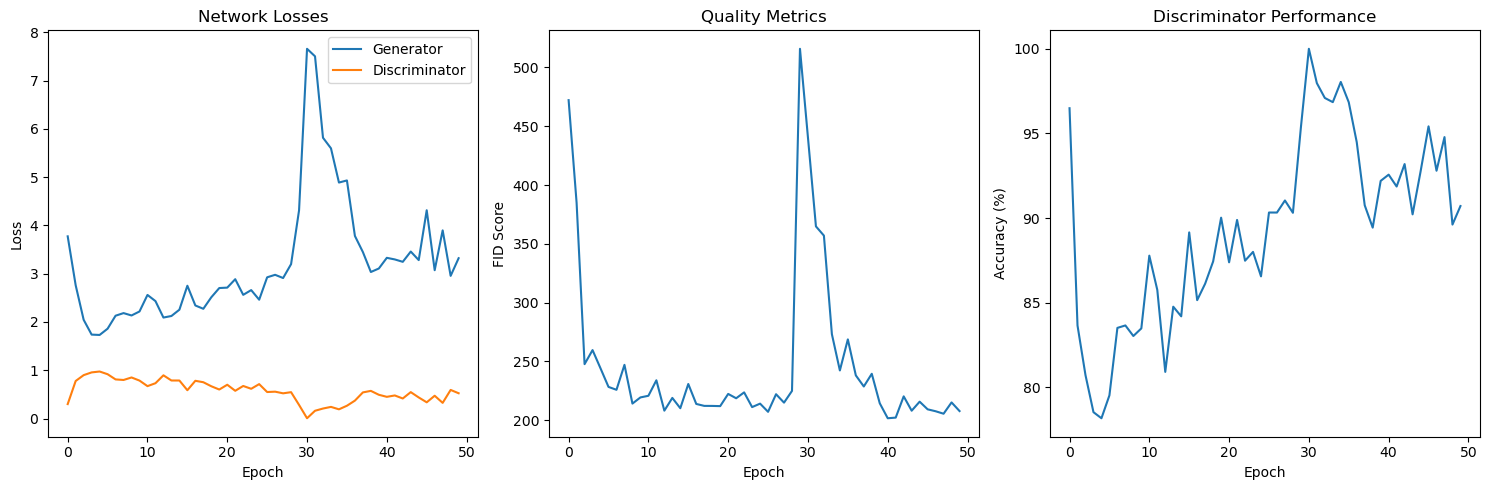


Training Completed
Final Metrics:
Generator Loss: 3.3197
Discriminator Loss: 0.5231
Discriminator Accuracy: 90.71%
Quality Score: 207.7875


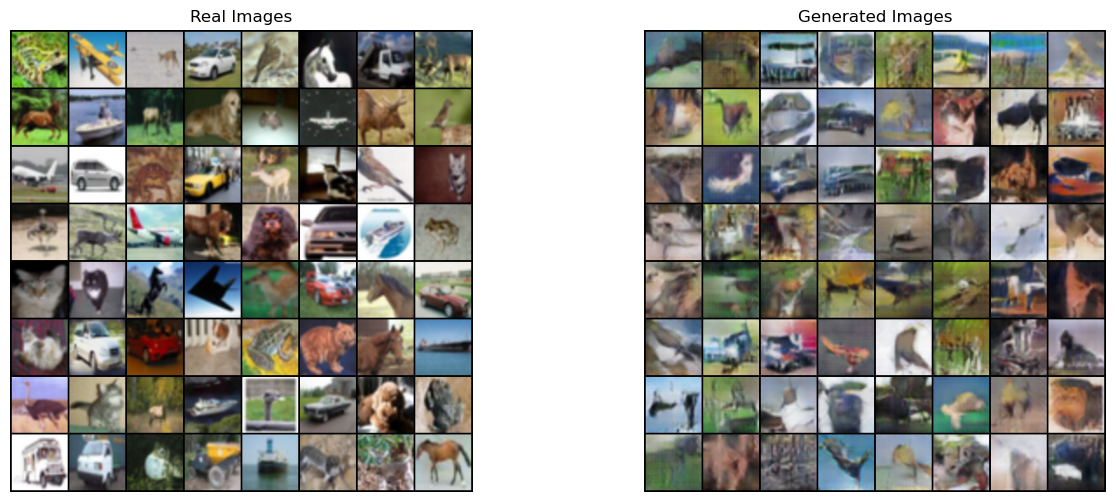


Results saved in DCGAN_results directory


In [6]:
# Cell 6: Execute Training and Display Final Results
# Initialize models
gen_model = Generator().to(device)
disc_model = Discriminator().to(device)
gen_model.apply(weight_init)
disc_model.apply(weight_init)

# Train models
print(f"Training on {device}")
gen_losses, disc_losses, quality_metrics, accuracies = train_networks(gen_model, disc_model, cifar_loader)

# Plot training curves
plot_training_curves(gen_losses, disc_losses, quality_metrics, accuracies)

print(f"\nTraining Completed")
print(f"Final Metrics:")
print(f"Generator Loss: {gen_losses[-1]:.4f}")
print(f"Discriminator Loss: {disc_losses[-1]:.4f}")
print(f"Discriminator Accuracy: {accuracies[-1]:.2f}%")
print(f"Quality Score: {quality_metrics[-1]:.4f}")

# Display final comparison
with torch.no_grad():
   final_generated = gen_model(torch.randn(64, MODEL_PARAMS['noise_dim'], 1, 1, device=device))
   plt.figure(figsize=(15, 6))
   
   plt.subplot(1, 2, 1)
   plt.axis("off")
   plt.title("Real Images")
   plt.imshow(np.transpose(utils.make_grid(
       initial_samples[0][:64].to(device), padding=2, normalize=True).cpu(), (1, 2, 0)))
   
   plt.subplot(1, 2, 2)
   plt.axis("off")
   plt.title("Generated Images")
   plt.imshow(np.transpose(utils.make_grid(
       final_generated, padding=2, normalize=True).cpu(), (1, 2, 0)))
   
   plt.savefig(os.path.join(RESULTS_PATH, 'Metrics/final_comparison.png'))
   plt.show()

print("\nResults saved in DCGAN_results directory")